In [53]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from torchvision.models.resnet import ResNet18_Weights
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [54]:
root_dir = '/kaggle/input/crocodilo/new_fer2013_cropped/train'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

In [55]:
classes

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [56]:
dataset_path = '/kaggle/input/crocodilo/new_fer2013_cropped'

In [57]:
mean = 0.456
std = 0.224
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize(224),             
    transforms.RandomRotation(degrees=15),       
    transforms.RandomHorizontalFlip(p=0.5),     
    transforms.RandomVerticalFlip(p=0.5),   
    transforms.ToTensor(),
    transforms.Normalize([mean]*3, [std]*3)
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize(224),             
    transforms.ToTensor(),
    transforms.Normalize([mean]*3, [std]*3)
])

In [58]:
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform_train)
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val", transform=transform_test)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform_test)

In [59]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [60]:
train_labels = train_dataset.targets  
class_indices = list(range(len(classes)))
class_weights = compute_class_weight(
    'balanced', 
    classes=class_indices, 
    y=train_labels
)

In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


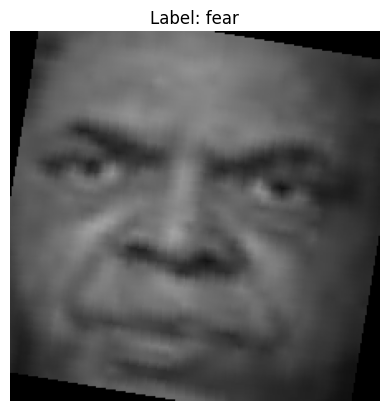

In [62]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[5].permute(1, 2, 0)  # C, H, W -> H, W, C
img = img * std + mean  # unnormalize back to [0,1] range
img = img.clamp(0, 1)
label = train_labels[0].item()
plt.imshow(img.numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

In [63]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [64]:
epochs = 55
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0001
)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, min_lr=1e-5)

In [65]:
def evaluate_train(model, loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    loss_total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_total += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    loss = loss_total / total
    acc = correct / total

    return loss, acc

In [66]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [67]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_acc = 0.0
epochs_without_improvement = 0 
patience = 8

for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0
    total_samples = 0

    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_correct += (torch.argmax(outputs, 1) == labels).sum().item()
        total_samples += labels.size(0)

    train_loss /= total_samples
    train_acc = train_correct / total_samples
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc = evaluate_train(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth') 
        print(f'Best model saved with val acc: {val_acc:.4f}')
        epochs_without_improvement = 0  
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {patience} epochs with no improvement.")
        break  

    print(f'EPOCH {epoch + 1}/{epochs}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tTrain accuracy: {train_acc:.4f}\tVal accuracy: {val_acc:.4f}')


Best model saved with val acc: 0.3453
EPOCH 1/55:	Train loss: 1.8635	Val loss: 1.7396	Train accuracy: 0.2157	Val accuracy: 0.3453
Best model saved with val acc: 0.4526
EPOCH 2/55:	Train loss: 1.6972	Val loss: 1.4244	Train accuracy: 0.3340	Val accuracy: 0.4526
Best model saved with val acc: 0.5207
EPOCH 3/55:	Train loss: 1.5003	Val loss: 1.2628	Train accuracy: 0.4312	Val accuracy: 0.5207
Best model saved with val acc: 0.5288
EPOCH 4/55:	Train loss: 1.3875	Val loss: 1.2201	Train accuracy: 0.4791	Val accuracy: 0.5288
Best model saved with val acc: 0.5335
EPOCH 5/55:	Train loss: 1.3352	Val loss: 1.2136	Train accuracy: 0.5021	Val accuracy: 0.5335
Best model saved with val acc: 0.5371
EPOCH 6/55:	Train loss: 1.2683	Val loss: 1.2102	Train accuracy: 0.5230	Val accuracy: 0.5371
Best model saved with val acc: 0.5441
EPOCH 7/55:	Train loss: 1.2174	Val loss: 1.2457	Train accuracy: 0.5406	Val accuracy: 0.5441
Best model saved with val acc: 0.5607
EPOCH 8/55:	Train loss: 1.1944	Val loss: 1.1455	Trai

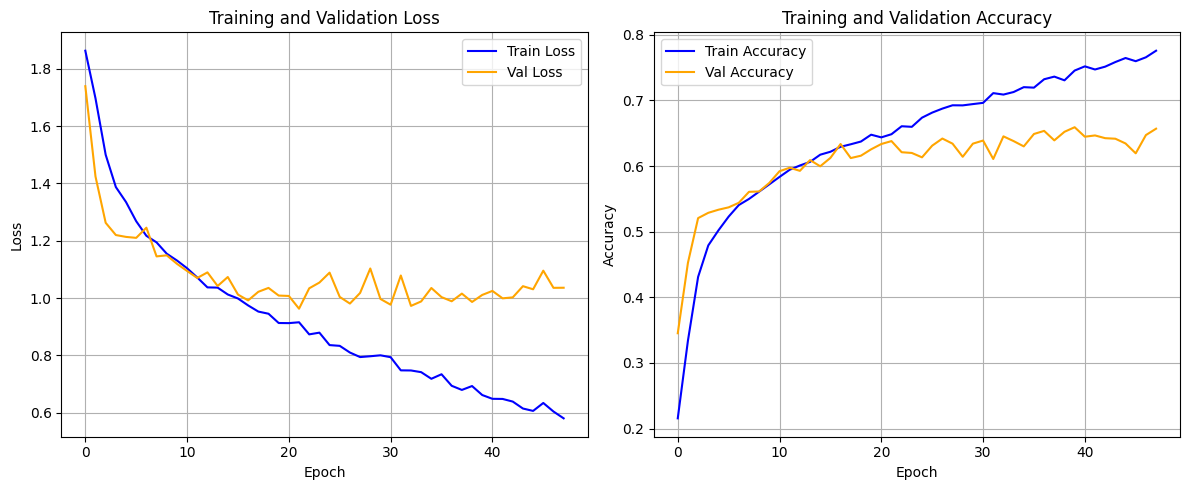

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(train_losses, color='blue', label='Train Loss')
ax[0].plot(val_losses, color='orange', label='Val Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(train_accs, color='blue', label='Train Accuracy')
ax[1].plot(val_accs, color='orange', label='Val Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [69]:
val_loss, val_acc = evaluate_train(
    model,
    val_loader,
    criterion,
    device,
)
test_loss, test_acc = evaluate_train(
    model,
    test_loader,
    criterion,
    device,
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6569363358354184
Test accuracy:  0.6555295689943201


In [70]:
def compute_classwise_metrics(y_true, y_pred, num_classes):
    precision = precision_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
    recall = recall_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
    f1 = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
    return precision, recall, f1

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_test(model, test_loader, criterion, device, num_classes):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy()) 
    
    precision, recall, f1 = compute_classwise_metrics(np.array(y_true), np.array(y_pred), num_classes)

    return precision, recall, f1, y_true, y_pred


         precision  recall      f1
angry       0.5843  0.5584  0.5711
disgust     0.6154  0.5714  0.5926
fear        0.5054  0.4012  0.4473
happy       0.8681  0.8704  0.8693
neutral     0.5876  0.6477  0.6162
sad         0.5078  0.4720  0.4893
surprise    0.7043  0.8654  0.7766





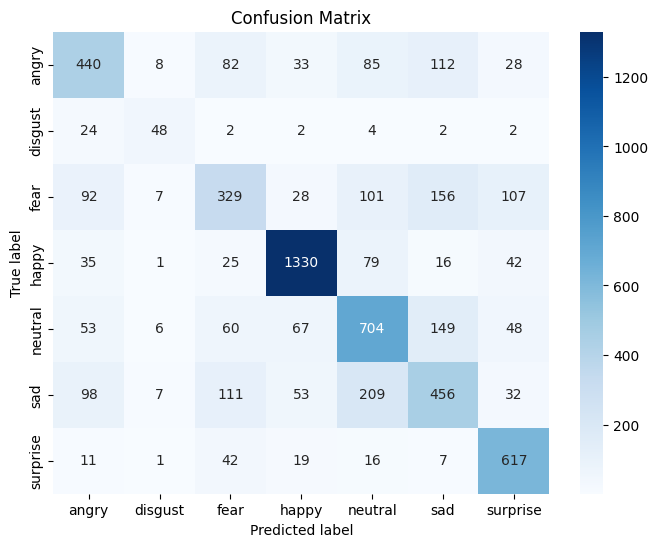

In [71]:
test_precision, test_recall, test_f1, y_true, y_pred = evaluate_test(
    model,
    test_loader,
    criterion,
    device,
   len(class_names)
)

data = {
    'precision': [f'{test_precision[i]:.4f}' for i in range(len(class_names))],
    'recall': [f'{test_recall[i]:.4f}' for i in range(len(class_names))],
    'f1': [f'{test_f1[i]:.4f}' for i in range(len(class_names))]
}
df = pd.DataFrame(data, index=class_names)
print(df)
print('\n\n')

cm = confusion_matrix(np.array(y_true), np.array(y_pred)) 
plot_confusion_matrix(cm, class_names)